In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import re
import os
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'
    
def read_dedup(x):
    samplename = os.path.basename(x)
    dedup_file = x + '/Combined/primary.deduplicated.dedup_metrics'
    if os.path.isfile(dedup_file)  and os.stat(dedup_file).st_size != 0:
        return pd.read_table(dedup_file,
                         skiprows = 6, nrows = 1)\
            .pipe(pd.melt)\
            .assign(samplename = samplename) 

In [27]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
samples = glob.glob(project_path + '/*R1_001')
samples = filter(lambda x: re.search('Q[cC][fF]', x), samples)
samples = filter(lambda x:  not re.search('L[0-9E]+', x), samples)
samples = list(samples)

df = map(read_dedup, samples)
df = filter(lambda x: x is not None, df)


y = 'ESTIMATED_LIBRARY_SIZE'
x = 'READ_PAIRS_EXAMINED'
df = pd.concat(df) \
    .pipe(lambda d: d[d.variable.str.contains("^%s$|^%s$|PERCENT_DUPLICATION" %(y,x))]) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .assign(value = lambda d: d['value'].astype(float))\
    .pipe(pd.pivot_table, 
              columns = 'variable', 
              values = 'value',
              index = ['samplename', 'prep'])\
    .reset_index()
df.head()

variable,samplename,prep,ESTIMATED_LIBRARY_SIZE,PERCENT_DUPLICATION,READ_PAIRS_EXAMINED
0,QCF1_R1_001,Unfragmented,101420.0,0.633663,254001.0
1,QCF2_R1_001,Unfragmented,138402.0,0.623973,335098.0
2,Qcf10_R1_001,Unfragmented,161161.0,0.305420,125450.0
3,Qcf11_R1_001,Unfragmented,78417.0,0.428008,97594.0
4,Qcf12_R1_001,Unfragmented,190597.0,0.306970,149399.0


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


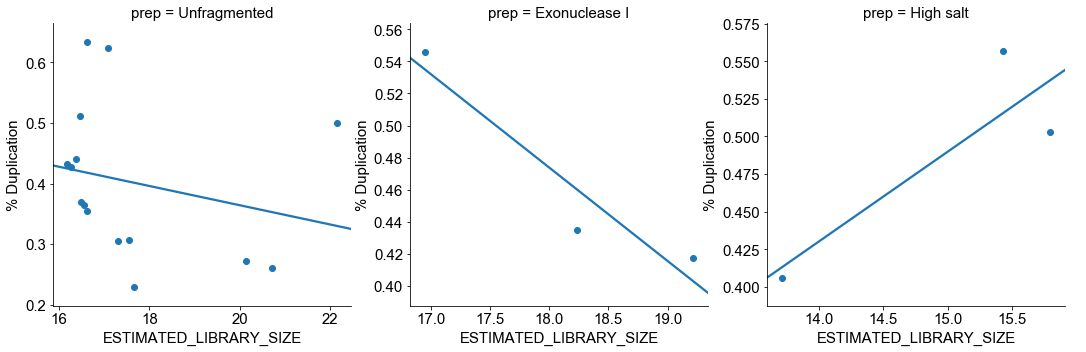

In [28]:
p = sns.FacetGrid(data = df\
                      .assign(log_x = lambda d: np.log2(d[x]))\
                      .assign(log_y = lambda d: np.log2(d[y]))\
                      .pipe(lambda d: d[~d.prep.str.contains('Unt|Al|^Fra')]), 
                  col = 'prep',size = 5, sharex=False, sharey=False)
p.map(sns.regplot, 'log_y', 'PERCENT_DUPLICATION',
      scatter_kws = {'alpha':1}, ci=None)
p.add_legend()
p.set(xlabel=y, ylabel = '% Duplication')
#p.set(xlim = (df[x].min()-100000,df[x].max()),
#     ylim = (df[y].min()-1000000, df[y].max()))

In [29]:
df = pd.concat(map(read_dedup, samples)) \
    .pipe(lambda d: d[d.variable.str.contains("PERCEN")]) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .sort_values('samplename') 
df

,variable,value,samplename,prep
8,PERCENT_DUPLICATION,0.633663,QCF1_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.623973,QCF2_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.30542,Qcf10_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.428008,Qcf11_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.30697,Qcf12_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.229177,Qcf13_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.354719,Qcf4_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.369198,Qcf5_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.511848,Qcf6_SS_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.363766,Qcf7_R1_001,Unfragmented


(0.1, 1)

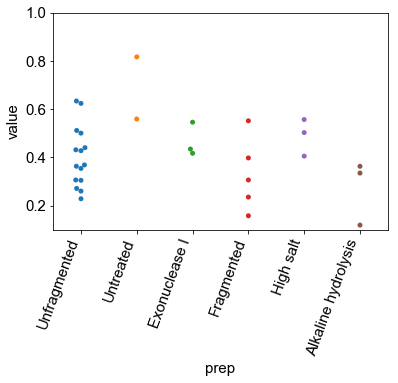

In [31]:
ax = plt.subplot() 
sns.swarmplot(data = df, x = 'prep', y = 'value', ax = ax)
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
ax.set_ylim(0.1,1)

In [21]:
df.assign(value = lambda d: d['value'].astype(float)).groupby('prep').agg({'value':['min','max','median']})

value                    
                          min       max    median
prep                                             
Alkaline hydrolysis  0.066638  0.363586  0.227787
Exonuclease I        0.417371  0.546037  0.435011
Fragmented           0.158723  0.551778  0.306966
High salt            0.405657  0.557042  0.503101
Unfragmented         0.229177  0.633663  0.369198
Untreated            0.078159  0.816332  0.559158

,prep,samplename,RNA_count,total_depth,sub_depth,cutoff
0,High salt,Qcf_HS1_R1_001,0,409904,40.9904,10
1,High salt,Qcf_HS2_R1_001,15,6841022,684.1022,10
2,High salt,Qcf_HS3_R1_001,17,9370652,937.0652,10
3,Low salt,QCF1_R1_001,33,11458003,1145.8003,10
4,Low salt,QCF2_R1_001,42,15628768,1562.8768,10


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


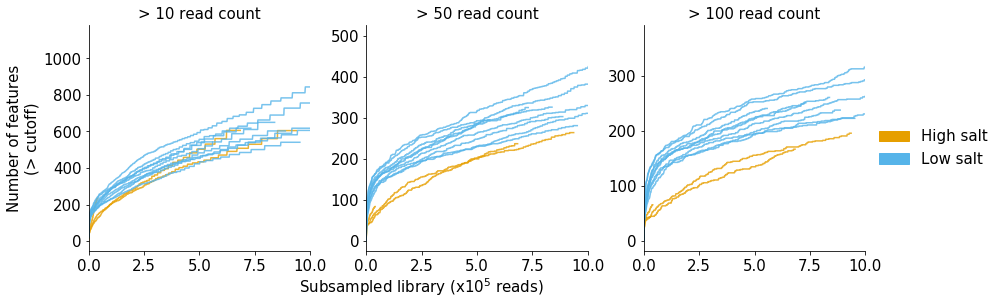